## 导入相关库

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from src.lib.utils.metric_show import *
from src.lib.utils.metrics import calculate_error
import matplotlib.animation as animation

## 导入数据

### 实验路径
baseline和当前best的

In [21]:
# 0sec
exp_dir = "/root/autodl-tmp/caoxiaoyan/urbanflood/exp/"
dataset_dir = "/root/autodl-tmp/caoxiaoyan/urbanflood/data/urbanflood22/test/flood/location16/r100y_p0.3_d3h_t6h"

baseline = "20240107_223311_284164"
best = "20240107_223311_284164"
baseline_exp_dir = os.path.join(exp_dir, baseline,"save_train_loss")
best_exp_dir = os.path.join(exp_dir, best,"save_train_loss")

key = "h" # 对比的变量
unit = 1000
sample_id = 0

### 加载实验结果
包括h、u、v的预测和实测值

In [22]:
# 2.5s
baseline_pred, label  = load_arrays_from_npz(sample_id, baseline_exp_dir, key=key)
best_pred,_ = load_arrays_from_npz(sample_id,best_exp_dir,  key=key)

## 计算

### 所有指标
```
axis=0: 得到空间的结果(500, 500)
axis=(1,2)：得到时间的结果(360,)
axis=None：得到整体结果，1个值(1,)
```

【每次评估都可以有一个值，axis=None】

像素级：MVAE（峰值误差）、MaxPAE（水深最大点的位置偏移）

图像级：MAE, MSE、SSIM（结构相似性）, PSNR（峰值信噪比）、MaxAE（误差的最大值）



【最后一次评估的时候按分钟画曲线，axis=(1,2)】

图像级：MAE, MSE、SSIM（结构相似性）, PSNR（峰值信噪比）、MaxAE（误差的最大值）、MVAE（峰值误差）



【给一幅图,axis=0】

图像级：MAE, MSE、MaxAE（误差的最大值，所在二维空间的散点密度图）、 MVAE（峰值误差）、MTAE（达峰时刻偏移误差）

#### 测下单位

In [23]:
u = baseline_pred[0]
print(u.max())
print(u.min())

u_label = label[0]
print(u_label.max())
print(u_label.min())

2.6150296
0.0
2.625239
0.0


#### 指标计算

##### 点、空间、时序的各项指标值

In [24]:
results = {"baseline":baseline_pred, 
           "best":best_pred}

metric_results={}
for name,val in results.items():
    metric_results[name] = {}
    for i, k in enumerate(key):
        point = calculate_error(val[i], label[i], axis=None)
        space =calculate_error(val[i], label[i], axis=0)
        series = calculate_error(val[i], label[i], axis=(1, 2))
        k_dict = {"point":point,
                  "space":space,
                  "series":series,
                  }
        metric_results[name][k] =k_dict
print(metric_results)

{'baseline': {'h': {'point': {'MaxVAE': -0.010209322, 'MaxTAE': None, 'MaxPAE': 0.0, 'MAE': 0.0011545545, 'MSE': 2.4905836e-05, 'SSIM': 0.9974690826955688, 'PSNR': 54.420375030765804, 'MaxAE': 0.753915}, 'space': {'MaxVAE': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'MaxTAE': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), 'MaxPAE': None, 'MAE': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), 'MSE': array([[0., 0., 

##### 获取最大误差时刻和对应的值

In [25]:


results = {"baseline":baseline_pred, 
           "best":best_pred}

AE_results={}
for name,val in results.items():
    AE_results[name] = {}
    for i, k in enumerate(key):
        max_error_timestep = cal_max_error_position(val[i],label[i])
        e = cal_Error(val[i][max_error_timestep], label[i][max_error_timestep])
        k_dict = {"error":e,
                  "frame":max_error_timestep,
                  "pred":val[i][max_error_timestep], 
                  "label":label[i][max_error_timestep],
                  }
        AE_results[name][k] =k_dict

## 可视化分析

### 动态误差

In [ ]:
# 3min2sec
save_dir = "figs/vis_metrics"
if not os.path.exists(save_dir):
    os.makedirs(save_dir,exist_ok=True)

for i, k in enumerate("h"):
    create_animation(baseline_pred[i], label[i], key="baseline_%s" % k,interval=50, save_dir=save_dir)
    create_animation(best_pred[i], label[i], key="best_%s" % k,interval=50, save_dir=save_dir)

#### 最大误差时刻

In [26]:
save_dir = "figs/vis_metrics/max_error"
if not os.path.exists(save_dir):
    os.makedirs(save_dir,exist_ok=True)

for name,val in results.items():
    for i, k in enumerate(key):
        pred_ = AE_results[name][k]["pred"]
        label_ = AE_results[name][k]["label"]
        error = AE_results[name][k]["error"]
        frame = AE_results[name][k]["frame"]
        vis_error(pred_, label_, error,
                  key=name+"_"+k, unit="m",
                  frame=frame, cmap = plt.cm.Set1,save_dir=save_dir)

ab_error: [0.00,0.75]
error: [-0.75,0.31]
ab_error: [0.00,0.75]
error: [-0.75,0.31]


### 单个误差值

像素级：MF AE（峰值误差）、MF PAE（水深最大点的位置偏移）
图像级：MAE, MSE、SSIM（结构相似性）, PSNR（峰值信噪比）、Max AE（误差的最大值）

In [27]:
import pandas as pd

def save_dict_to_excel(dictionary, filepath):
    # 将字典转换为DataFrame
    df = pd.DataFrame.from_dict(dictionary, orient='columns')

    # 将DataFrame转置为使行变为列
    df_transposed = df.transpose()

    # 将DataFrame保存到Excel文件
    df_transposed.to_excel(filepath,float_format="%.4f")

point_res = {}
for name,val in results.items():
    for i, k in enumerate(key):
        name_k_point = metric_results[name][k]["point"]
        point_res["_".join([name,k])] = name_k_point


save_dict_to_excel(point_res, 'output.xlsx')

### 逐分钟误差值
【最后一次评估的时候按分钟画曲线，axis=(1,2)】

图像级：MAE, MSE、SSIM（结构相似性）, PSNR（峰值信噪比）、MaxAE（误差的最大值）、MVAE（峰值误差）

In [28]:
save_dir = "figs/vis_metrics/series-train"
if not os.path.exists(save_dir):
    os.makedirs(save_dir,exist_ok=True)

metric_names = list(metric_results[list(metric_results.keys())[0]]["h"]["series"].keys())
print(metric_names)
for i, k in enumerate(key): # 变量
    for m in metric_names: # 指标
        key_metric = []
        for name,val in metric_results.items(): # 实验
            name_k_m_series = metric_results[name][k]["series"][m]
            if name_k_m_series is None:
                continue
            key_metric.append(name_k_m_series)
        if len(key_metric):
            vis_vs_mean_std(key_metric,  mean=None, std=None,
                            name=k+"-"+m, save_dir=save_dir, data_type=["baseline","best"],fontsize=20)

['MaxVAE', 'MaxTAE', 'MaxPAE', 'MAE', 'MSE', 'SSIM', 'PSNR', 'MaxAE']


<Figure size 800x1200 with 0 Axes>

<Figure size 800x1200 with 0 Axes>

<Figure size 800x1200 with 0 Axes>

<Figure size 800x1200 with 0 Axes>

<Figure size 800x1200 with 0 Axes>

<Figure size 800x1200 with 0 Axes>

### 空间误差值

【给一幅图,axis=0】

图像级：MAE, MSE、MaxAE（误差的最大值，所在二维空间的散点密度图）、 MVAE（峰值误差）、MTAE（达峰时刻偏移误差）

In [29]:


save_dir = "figs/vis_metrics/train-space"
if not os.path.exists(save_dir):
    os.makedirs(save_dir,exist_ok=True)

metric_names = list(metric_results[list(metric_results.keys())[0]]["h"]["space"].keys())
print(metric_names)

for i, k in enumerate(key): # 变量
    for m in metric_names: # 指标
        key_metric = []
        exp_list=[]
        vmax = -999
        vmin = 999
        for name,val in metric_results.items(): # 实验
            name_k_m_series = metric_results[name][k]["space"][m]
            if name_k_m_series is None:
                break
            key_metric.append(name_k_m_series)
            if vmax < np.max(name_k_m_series):
                vmax = np.max(name_k_m_series)
            if vmin > np.min(name_k_m_series):
                vmin =np.min(name_k_m_series)
            
            exp_list.append(name)
        if len(key_metric):
            vs_visualize_metric_space(key_metric, k+"-"+m, 
                                      exp_list, vmax, vmin, save_dir)

['MaxVAE', 'MaxTAE', 'MaxPAE', 'MAE', 'MSE', 'SSIM', 'PSNR', 'MaxAE']


### 整体误差


#### 每个点位的mse, mae, NSE （得到）

In [30]:
# 12.4sec
save_dir = "figs/vis_metrics/train-2d_metrics"
if not os.path.exists(save_dir):
    os.makedirs(save_dir,exist_ok=True)

for i, k in enumerate("h"):
    mse_baseline = calculate_mse(baseline_pred[i], label[i])
    mae_baseline = calculate_mae(baseline_pred[i], label[i])
    nse_baseline = calculate_r2(baseline_pred[i], label[i])
    mse_best = calculate_mse(best_pred[i], label[i])
    mae_best = calculate_mae(best_pred[i], label[i])
    nse_best = calculate_r2(best_pred[i], label[i])
    
    mse_max= np.max([mse_baseline.max(),mse_best.max()])
    mse_min= np.max([mse_baseline.min(),mse_best.min()])
    mae_max= np.max([mae_baseline.max(),mae_best.max()])
    mae_min= np.max([mae_baseline.min(),mae_best.min()])
    nse_max= np.max([nse_baseline.max(),nse_best.max()])
    nse_min= np.max([nse_baseline.min(),nse_best.min()])

    # 单个画
    # visualize_2d_metric(mse_baseline, vmax=mse_max,vmin=mse_min, metric_name="MSE", key="baseline_h", save_dir=save_dir)
    # visualize_2d_metric(mae_baseline, vmax=mae_max,vmin=mae_min,metric_name="MAE", key="baseline_h", save_dir=save_dir)
    # visualize_2d_metric(nse_baseline, vmax=nse_max,vmin=nse_min,metric_name="NSE", key="baseline_h", save_dir=save_dir)
    # visualize_2d_metric(mse_best, vmax=mse_max,vmin=mse_min,metric_name="MSE", key="best_h", save_dir=save_dir)
    # visualize_2d_metric(mae_best, vmax=mae_max,vmin=mae_min,metric_name="MAE", key="best_h", save_dir=save_dir)
    # visualize_2d_metric(nse_best, vmax=nse_max,vmin=nse_min,metric_name="NSE", key="best_h", save_dir=save_dir)

    # 对比baseline与best
    vs_visualize_2d_metric(mse_baseline, mse_best, vmax=mse_max,vmin=mse_min, metric_name="MSE", key1="baseline_%s" % k, key2="best_%s" % k,save_dir=save_dir)
    vs_visualize_2d_metric(mae_baseline, mae_best, vmax=mae_max,vmin=mae_min, metric_name="MAE", key1="baseline_%s" % k, key2="best_%s" % k,save_dir=save_dir)
    vs_visualize_2d_metric(nse_baseline, nse_best, vmax=nse_max,vmin=nse_min, metric_name="NSE", key1="baseline_%s" % k, key2="best_%s" % k,save_dir=save_dir)

#### 绘制密度散点图

In [ ]:
# 78min
save_dir = "figs/train-vis_metrics"
if not os.path.exists(save_dir):
    os.makedirs(save_dir,exist_ok=True)

frame = 100
for i, k in enumerate("h"):
    density_scatter_plot(baseline_pred[i][frame-1].flatten(), label[i][frame-1].flatten(), key="baseline_%s" % k, save_dir=save_dir)
    density_scatter_plot(best_pred[i][frame-1].flatten(), label[i][frame-1].flatten(), key="best_%s" % k, save_dir=save_dir)

#### 绘制误差值的频率分布直方图

2.625239


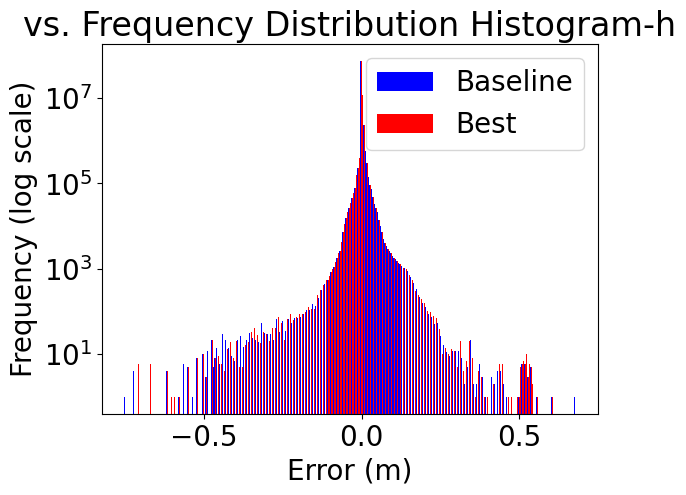

In [31]:
# 23.2sec
save_dir = "figs/train-vis_metrics"
if not os.path.exists(save_dir):
    os.makedirs(save_dir,exist_ok=True)

# print(baseline_pred[0].shape)
# print(len(list(label)))
print(label[0].max())
for i, k in enumerate("h"):
    # print("baseline_pred[i].flatten():",len(baseline_pred[i].flatten()))
    # print("best_pred[i].flatten():",len(best_pred[i].flatten()))
    # print("label[i].flatten():",len(label[i].flatten()))
    vs_plot_error_histogram(baseline_pred[i].flatten(), best_pred[i].flatten(),
                            label[i].flatten(), key=k,
                            xlim=None, ylim=None, save_dir=save_dir)

#### 绘制分段水深误差对比图

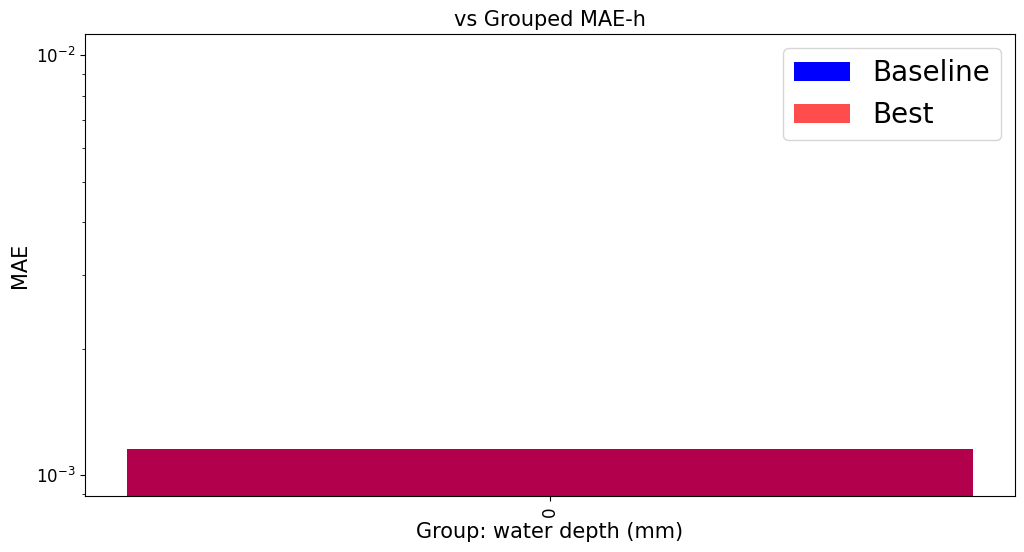

In [32]:
# 44.7sec
save_dir = "figs/vis_metrics"
if not os.path.exists(save_dir):
    os.makedirs(save_dir,exist_ok=True)

intc = 50 # 分组间隔mm

# # baseline
# pred = baseline_pred[0].flatten()
# label = baseline_pred[3].flatten()
# vmin, vmax = label.min(), np.max([label.max(),pred.max()])
# vis_group_error(pred, label, vmin, vmax, intc,key="baseline_h", save_dir=save_dir)

# # best
# pred = best_pred[0].flatten()
# label = best_pred[3].flatten()
# vmin, vmax = label.min(), np.max([label.max(),pred.max()])
# vis_group_error(pred, label, vmin, vmax, intc,key="best_h", save_dir=save_dir)

for i, k in enumerate("h"):
    label_k = label[i].flatten()
    baseline_pred = baseline_pred[i].flatten()
    best_pred = best_pred[i].flatten()
    vmin, vmax = label_k.min(), np.max([label_k.max(),baseline_pred.max(),best_pred.max()])
    vs_vis_group_error(baseline_pred, best_pred, label_k, k,vmin, vmax, intc, save_dir)

#### TODO: 每个时刻的误差对比

# 所有事件的整体值

In [33]:
from sklearn.metrics import mean_squared_error
# 0sec

def cal_max_AE(pred, label, axis):
    error = pred - label
    ae = np.abs(error)
    return np.max(ae, axis)

def cal_MSE(pred, label, axis):
    return np.mean((pred - label) ** 2, axis)

def cal_MAE(pred, label, axis):
    return np.mean(np.abs(pred - label), axis)
    
exp_dir = "/root/autodl-tmp/caoxiaoyan/urbanflood/exp/"

baseline = "20231103_192206_771605"
best = "20231103_192238_103755"
baseline_exp_dir = os.path.join(exp_dir, baseline,"save_train_loss")
best_exp_dir = os.path.join(exp_dir, best,"save_train_loss")

key = "h" # 对比的变量
unit = 1000
sample_id = 0


all_mse = []
all_mae = []
all_maxae = []

folder_path = baseline_exp_dir
for x in range(1):  # loop from 0 to 7
    label_path = f"{folder_path}/label_{x}.npz"
    pred_path = f"{folder_path}/pred_{x}.npz"
    # print(label_path)
    # print(pred_path)
    # Load data from files
    label_data = np.load(label_path)
    pred_data = np.load(pred_path)
    
    label_h = label_data["label_h"][0].flatten() / 1000
    pred_h = pred_data["pred_h"][0].flatten()  / 1000
    
    # Calculate MSE
    mse = cal_MSE(pred_h, label_h, axis=None)
    mae = cal_MAE(pred_h, label_h, axis=None)
    maxae = cal_max_AE(pred_h, label_h, axis=None)
    # print("mse:",mse)
    # print("mae:",mae)
    all_mae.append(mae)
    all_mse.append(mse)
    all_maxae.append(maxae)

# Calculate overall MSE
overall_mae = np.mean(all_mae)
overall_mse = np.mean(all_mse)
overall_maxae = np.mean(all_maxae)
print("Overall MAE:", overall_mae)
print("Overall MSE:", overall_mse)
print("Overall MAXAE:", overall_maxae)

Overall MAE: 0.0032172208
Overall MSE: 0.00030302853
Overall MAXAE: 1.167209
